In [15]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
from matplotlib import cm
import pandas as pd
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [16]:
n_individuals = 400 
n_demes = 20 
bits_in_indiv = 40 
n_individuals_per_deme = int(n_individuals / n_demes)
bits_per_side = int(bits_in_indiv / 2)


In [17]:
@np.vectorize
def pure_fitness(x,y):
    return 2**float(x) + 2**float(y) 

def noise(x,y, bits_per_side):
    return np.random.uniform(0.5, 1, size = (bits_per_side, bits_per_side))

def create_fitness_landscape(bits_per_side):
    mesh_x, mesh_y = np.meshgrid(np.arange(0, bits_per_side), np.arange(0, bits_per_side))
    noise_land = noise(mesh_x, mesh_y, bits_per_side)
    pure_fitness_land = pure_fitness(mesh_x, mesh_y)
    return mesh_x, mesh_y, (pure_fitness_land * noise_land), noise_land, pure_fitness_land


In [18]:
x, y, fitness_land, noise_land, pure_fitness_land = create_fitness_landscape(50)


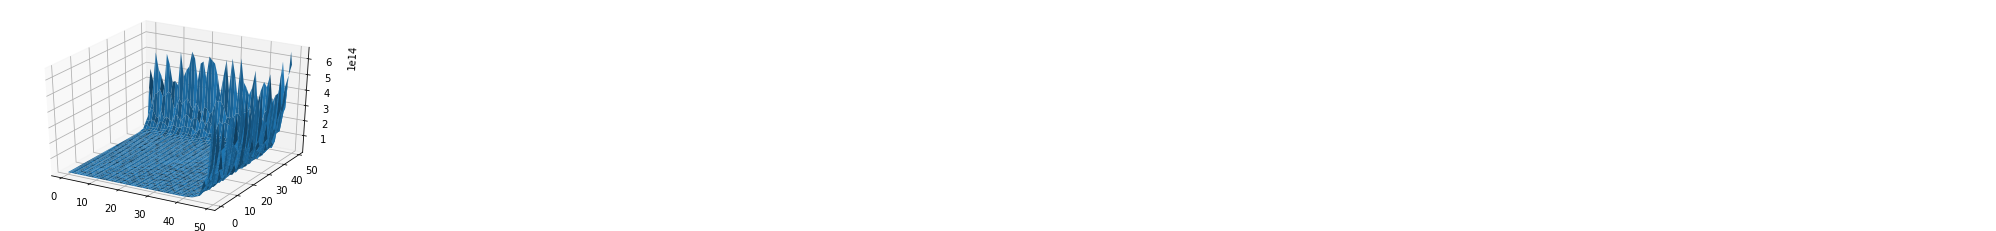

In [19]:
fig = plt.figure()
ax = fig.gca(projection = "3d")
surf = ax.plot_surface(x, y , fitness_land)

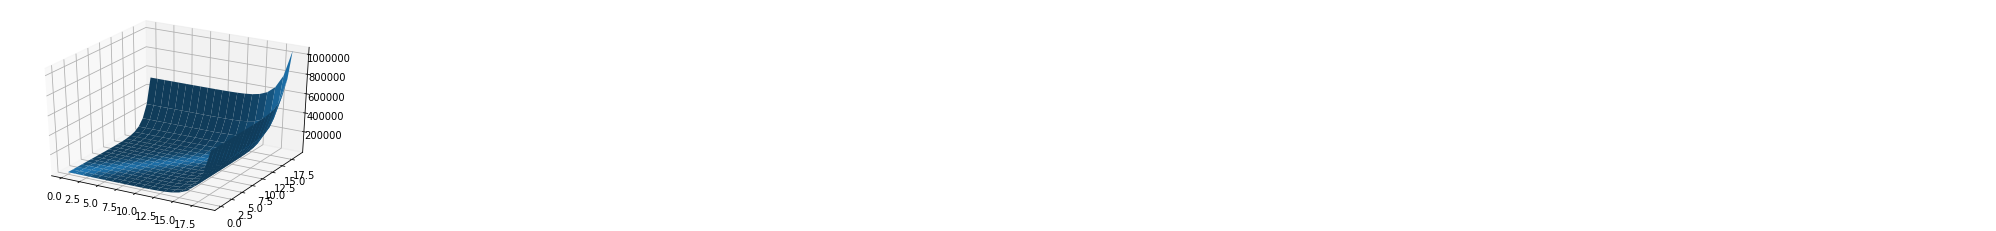

In [573]:
fig = plt.figure()
ax = fig.gca(projection = "3d")
surf = ax.plot_surface(x, y, pure_fitness_land)

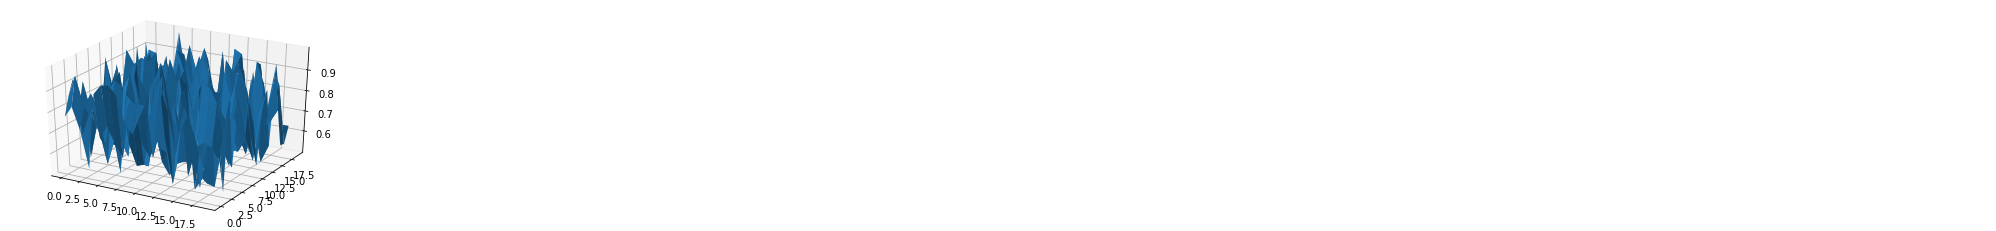

In [574]:
fig = plt.figure()
ax = fig.gca(projection = "3d")
surf_noise = ax.plot_surface(x,y, noise_land)

In [1126]:
def fitness_function(bit_string):
    x = sum(bit_string[0 :  bits_per_side])
    y = sum(bit_string[bits_per_side :])
    print(x, y) 
    return 2**x + 2**y

In [1127]:
def initialise_individuals(bits_in_indiv, n_individuals_per_deme):
    return np.random.randint(0,2, size=(bits_in_indiv, n_individuals_per_deme))

In [1134]:
@profile
def individual_fitnesses(indivs, bits_per_side):
    x = [max(sum(t[0: bits_per_side]) -1, 0)  for t in indivs]
    y = [max(sum(t[bits_per_side :]) -1,0) for t in indivs]
    return fitness_land[x ,y ]

def get_person_fitness(person, bits_per_side):
    max_bit = (bits_per_side - 1)
    return fitness_land[max(sum(person[0: bits_per_side])-1, 0), max(sum(person[bits_per_side:])-1, 0)]

@profile
def get_individual_probabilities(fitnesses):
    return  fitnesses / sum(fitnesses)

@profile
def get_max_index(probs):
    return probs.argmax()


@profile
def selection(probs, max_fit, indivs, bits_per_side):
    sel = np.random.rand(len(probs)- 1)
    sel.sort()
    current_tot = 0
    index = 0
    selected = []
    for it in sel:
        while(current_tot < it):
            current_tot += probs[index]
            index += 1
        if index < len(probs) - 1:    
            selected.append(index)
        else:
            selected.append(index - 1)
    elite = indivs[probs.argmax(), :]
    elite_score = get_person_fitness(elite, bits_per_side)
    return selected, elite, elite_score == max_fit
    
@profile   
def fitness_prop_selection(indivs, max_fit, bits_per_side):
    fitnesses = individual_fitnesses(indivs, bits_per_side)
    probs = get_individual_probabilities(fitnesses)
    return selection(probs, max_fit, indivs, bits_per_side)


In [1135]:
@profile
def mutation(indv, mutation_rate, bits_in_indiv):
    return np.bitwise_xor(indv, np.random.uniform(0,1, size = bits_in_indiv) <= mutation_rate)
    #return [indv[t] ^ indexes_to_mutatate[t] for t in range(bits_in_indiv) ]

@profile    
def one_point_crossover(indiv_a,indiv_b):
    crossover_point = random.randint(0, len(indiv_a) - 1)
    return np.concatenate([indiv_a[: crossover_point], indiv_b[crossover_point:]])

@profile
def migration(demes, no_indiv, no_genes, no_demes):
    for i, deme in enumerate(demes):
        migrant = demes[random.randint(0, no_demes - 1)][random.randint(0, no_indiv - 2),:]
        migrant = migrant.reshape(1, no_genes)
        demes[i] = np.concatenate([deme, migrant])
    return demes

def apply_crossover(demes, no_of_demes, no_indiv):
    for i, deme in enumerate(demes):
        crossed_deme = [] 
        for t in range(no_indiv):
            if(t < no_indiv - 1):
                new_indiv = one_point_crossover(deme[random.randint(0, no_indiv),:], deme[random.randint(0, no_indiv),:])
            else:
                new_indiv = deme[t, :]
            crossed_deme.append(new_indiv)
        demes[i] = np.asarray(crossed_deme)
    return demes
    

In [1136]:
@profile
def round(demes, no_indiv, bits_in_indiv, max_xy, crossover, bits_per_side):
    no_of_demes = len(demes)
    mutation_rate = 1 / bits_in_indiv
    new_demes = [] 
    for i,deme in enumerate(demes):
        selected_indexs, max_pop, max_found = fitness_prop_selection(deme, max_xy, bits_per_side)
        if max_found:
            return "max found"
        prop_selected = deme[selected_indexs,:]
        mutated = np.array([mutation(x, mutation_rate, bits_in_indiv) for x in prop_selected])        
        demes[i] = np.concatenate([mutated, max_pop.reshape(1, bits_in_indiv )], axis = 0)
    demes = migration(demes, no_indiv, bits_in_indiv, no_of_demes)
    if crossover:
        demes = apply_crossover(demes, no_of_demes, no_indiv)
    return demes
        
                    

First we create the seperate demes

In [1137]:
n_individuals = 400 
n_demes = 20 
bits_in_indiv = 40 
n_individuals_per_deme = int(n_individuals / n_demes)


In [1146]:
import line_profiler

@profile
def apply_rounds(demes, n_individuals_per_deme, bits_in_indiv, fittest_index, crossover_included, bits_per_side):
    for r in range(2000):
        if crossover_included:
            demes = round(demes, n_individuals_per_deme, bits_in_indiv, fittest_index, crossover_included, bits_per_side)
        else:
            demes = mutation_round(demes, n_individuals_per_deme, bits_in_indiv, fittest_index, crossover_included, bits_per_side)
        if demes == "max found":
            return r 
            break
    return -1

@profile  
def init_pops(n_individuals_per_deme, bits_in_indiv, n_demes):
    demes_cross = []
    demes_mut = initialise_individuals(n_individuals_per_deme * n_demes, bits_in_indiv)
    for x in range(n_demes):
        initalised = initialise_individuals(n_individuals_per_deme, bits_in_indiv)
        demes_cross.append(initalised)
    return demes_cross, demes_mut

def mutation_round(demes_mut, n_individuals_per_deme, bits_in_indiv, fittest, cross, bits_per_side):
        mutation_rate = 1 /  bits_in_indiv
        selected_indexs, max_pop, max_found = fitness_prop_selection(demes_mut, fittest, bits_per_side)
        if max_found:
            return "max found"
        
        prop_selected = demes_mut[selected_indexs,:]
        mutated = np.array([mutation(x, mutation_rate, bits_in_indiv) for x in prop_selected])        
        demes_mut = np.concatenate([mutated, max_pop.reshape(1, bits_in_indiv )], axis = 0)
        return demes_mut
        
    
        

In [1148]:
results = pd.DataFrame(columns=['bit_size', 'round', 'crossover', 'mutation'])
for t in range(10, 90, 10):
    for try_no in range(30):
        print('t = ', t, ' try : ', try_no)
        bits_in_indiv = t 
        bits_per_side = int(t / 2)
        x, y, fitness_land, noise_land, pure_fitness_land = create_fitness_landscape(bits_per_side)
        fittest = np.max(fitness_land)
        demes_cross, demes_mut = init_pops(n_individuals_per_deme, bits_in_indiv, n_demes)
        if t <= 70:  
            print('starting mut')
            mut_res = apply_rounds(demes_mut, n_individuals_per_deme, bits_in_indiv, fittest, False, bits_per_side)
        else:
            mut_res = -1 
        print('starting cross')
        cross_res = apply_rounds(demes_cross, n_individuals_per_deme, bits_in_indiv, fittest, True, bits_per_side)
        results = results.append({'bit_size': bits_in_indiv,
                        'round' : try_no,
                        'crossover' : cross_res,
                        'mutation' : mut_res}, ignore_index=True)
        print(results)

print(results)


            
            



t =  10  try :  0
starting mut
starting cross
  bit_size round crossover mutation
0       10     0         1        3
t =  10  try :  1
starting mut
starting cross
  bit_size round crossover mutation
0       10     0         1        3
1       10     1         0        0
t =  10  try :  2
starting mut
starting cross
  bit_size round crossover mutation
0       10     0         1        3
1       10     1         0        0
2       10     2         0        1
t =  10  try :  3
starting mut
starting cross
  bit_size round crossover mutation
0       10     0         1        3
1       10     1         0        0
2       10     2         0        1
3       10     3         2        0
t =  10  try :  4


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD from sys.path while we load stuff.


starting mut
starting cross
  bit_size round crossover mutation
0       10     0         1        3
1       10     1         0        0
2       10     2         0        1
3       10     3         2        0
4       10     4         1        4
t =  10  try :  5
starting mut
starting cross
  bit_size round crossover mutation
0       10     0         1        3
1       10     1         0        0
2       10     2         0        1
3       10     3         2        0
4       10     4         1        4
5       10     5         1        3
t =  10  try :  6
starting mut
starting cross
  bit_size round crossover mutation
0       10     0         1        3
1       10     1         0        0
2       10     2         0        1
3       10     3         2        0
4       10     4         1        4
5       10     5         1        3
6       10     6         0        0
t =  10  try :  7
starting mut
starting cross
  bit_size round crossover mutation
0       10     0         1        3
1     

   bit_size round crossover mutation
0        10     0         1        3
1        10     1         0        0
2        10     2         0        1
3        10     3         2        0
4        10     4         1        4
5        10     5         1        3
6        10     6         0        0
7        10     7         0        2
8        10     8         1        3
9        10     9         4        0
10       10    10         2        4
11       10    11         0        1
12       10    12         0        0
13       10    13         1        3
14       10    14         4        0
15       10    15         1        2
16       10    16         1        0
17       10    17         0        0
18       10    18         0        1
19       10    19         1        5
20       10    20         0        0
21       10    21         0        0
22       10    22         0        0
23       10    23         1        0
24       10    24         2        3
t =  10  try :  25
starting mut
starti

   bit_size round crossover mutation
0        10     0         1        3
1        10     1         0        0
2        10     2         0        1
3        10     3         2        0
4        10     4         1        4
5        10     5         1        3
6        10     6         0        0
7        10     7         0        2
8        10     8         1        3
9        10     9         4        0
10       10    10         2        4
11       10    11         0        1
12       10    12         0        0
13       10    13         1        3
14       10    14         4        0
15       10    15         1        2
16       10    16         1        0
17       10    17         0        0
18       10    18         0        1
19       10    19         1        5
20       10    20         0        0
21       10    21         0        0
22       10    22         0        0
23       10    23         1        0
24       10    24         2        3
25       10    25         2        1
2

   bit_size round crossover mutation
0        10     0         1        3
1        10     1         0        0
2        10     2         0        1
3        10     3         2        0
4        10     4         1        4
5        10     5         1        3
6        10     6         0        0
7        10     7         0        2
8        10     8         1        3
9        10     9         4        0
10       10    10         2        4
11       10    11         0        1
12       10    12         0        0
13       10    13         1        3
14       10    14         4        0
15       10    15         1        2
16       10    16         1        0
17       10    17         0        0
18       10    18         0        1
19       10    19         1        5
20       10    20         0        0
21       10    21         0        0
22       10    22         0        0
23       10    23         1        0
24       10    24         2        3
25       10    25         2        1
2

starting cross
   bit_size round crossover mutation
0        10     0         1        3
1        10     1         0        0
2        10     2         0        1
3        10     3         2        0
4        10     4         1        4
5        10     5         1        3
6        10     6         0        0
7        10     7         0        2
8        10     8         1        3
9        10     9         4        0
10       10    10         2        4
11       10    11         0        1
12       10    12         0        0
13       10    13         1        3
14       10    14         4        0
15       10    15         1        2
16       10    16         1        0
17       10    17         0        0
18       10    18         0        1
19       10    19         1        5
20       10    20         0        0
21       10    21         0        0
22       10    22         0        0
23       10    23         1        0
24       10    24         2        3
25       10    25      

   bit_size round crossover mutation
0        10     0         1        3
1        10     1         0        0
2        10     2         0        1
3        10     3         2        0
4        10     4         1        4
5        10     5         1        3
6        10     6         0        0
7        10     7         0        2
8        10     8         1        3
9        10     9         4        0
10       10    10         2        4
11       10    11         0        1
12       10    12         0        0
13       10    13         1        3
14       10    14         4        0
15       10    15         1        2
16       10    16         1        0
17       10    17         0        0
18       10    18         0        1
19       10    19         1        5
20       10    20         0        0
21       10    21         0        0
22       10    22         0        0
23       10    23         1        0
24       10    24         2        3
25       10    25         2        1
2

starting cross
   bit_size round crossover mutation
0        10     0         1        3
1        10     1         0        0
2        10     2         0        1
3        10     3         2        0
4        10     4         1        4
5        10     5         1        3
6        10     6         0        0
7        10     7         0        2
8        10     8         1        3
9        10     9         4        0
10       10    10         2        4
11       10    11         0        1
12       10    12         0        0
13       10    13         1        3
14       10    14         4        0
15       10    15         1        2
16       10    16         1        0
17       10    17         0        0
18       10    18         0        1
19       10    19         1        5
20       10    20         0        0
21       10    21         0        0
22       10    22         0        0
23       10    23         1        0
24       10    24         2        3
25       10    25      

starting cross
   bit_size round crossover mutation
0        10     0         1        3
1        10     1         0        0
2        10     2         0        1
3        10     3         2        0
4        10     4         1        4
5        10     5         1        3
6        10     6         0        0
7        10     7         0        2
8        10     8         1        3
9        10     9         4        0
10       10    10         2        4
11       10    11         0        1
12       10    12         0        0
13       10    13         1        3
14       10    14         4        0
15       10    15         1        2
16       10    16         1        0
17       10    17         0        0
18       10    18         0        1
19       10    19         1        5
20       10    20         0        0
21       10    21         0        0
22       10    22         0        0
23       10    23         1        0
24       10    24         2        3
25       10    25      

starting cross
   bit_size round crossover mutation
0        10     0         1        3
1        10     1         0        0
2        10     2         0        1
3        10     3         2        0
4        10     4         1        4
5        10     5         1        3
6        10     6         0        0
7        10     7         0        2
8        10     8         1        3
9        10     9         4        0
10       10    10         2        4
11       10    11         0        1
12       10    12         0        0
13       10    13         1        3
14       10    14         4        0
15       10    15         1        2
16       10    16         1        0
17       10    17         0        0
18       10    18         0        1
19       10    19         1        5
20       10    20         0        0
21       10    21         0        0
22       10    22         0        0
23       10    23         1        0
24       10    24         2        3
25       10    25      

starting cross
   bit_size round crossover mutation
0        10     0         1        3
1        10     1         0        0
2        10     2         0        1
3        10     3         2        0
4        10     4         1        4
5        10     5         1        3
6        10     6         0        0
7        10     7         0        2
8        10     8         1        3
9        10     9         4        0
10       10    10         2        4
11       10    11         0        1
12       10    12         0        0
13       10    13         1        3
14       10    14         4        0
15       10    15         1        2
16       10    16         1        0
17       10    17         0        0
18       10    18         0        1
19       10    19         1        5
20       10    20         0        0
21       10    21         0        0
22       10    22         0        0
23       10    23         1        0
24       10    24         2        3
25       10    25      

   bit_size round crossover mutation
0        10     0         1        3
1        10     1         0        0
2        10     2         0        1
3        10     3         2        0
4        10     4         1        4
5        10     5         1        3
6        10     6         0        0
7        10     7         0        2
8        10     8         1        3
9        10     9         4        0
10       10    10         2        4
11       10    11         0        1
12       10    12         0        0
13       10    13         1        3
14       10    14         4        0
15       10    15         1        2
16       10    16         1        0
17       10    17         0        0
18       10    18         0        1
19       10    19         1        5
20       10    20         0        0
21       10    21         0        0
22       10    22         0        0
23       10    23         1        0
24       10    24         2        3
25       10    25         2        1
2

starting cross
   bit_size round crossover mutation
0        10     0         1        3
1        10     1         0        0
2        10     2         0        1
3        10     3         2        0
4        10     4         1        4
5        10     5         1        3
6        10     6         0        0
7        10     7         0        2
8        10     8         1        3
9        10     9         4        0
10       10    10         2        4
11       10    11         0        1
12       10    12         0        0
13       10    13         1        3
14       10    14         4        0
15       10    15         1        2
16       10    16         1        0
17       10    17         0        0
18       10    18         0        1
19       10    19         1        5
20       10    20         0        0
21       10    21         0        0
22       10    22         0        0
23       10    23         1        0
24       10    24         2        3
25       10    25      

starting cross
   bit_size round crossover mutation
0        10     0         1        3
1        10     1         0        0
2        10     2         0        1
3        10     3         2        0
4        10     4         1        4
5        10     5         1        3
6        10     6         0        0
7        10     7         0        2
8        10     8         1        3
9        10     9         4        0
10       10    10         2        4
11       10    11         0        1
12       10    12         0        0
13       10    13         1        3
14       10    14         4        0
15       10    15         1        2
16       10    16         1        0
17       10    17         0        0
18       10    18         0        1
19       10    19         1        5
20       10    20         0        0
21       10    21         0        0
22       10    22         0        0
23       10    23         1        0
24       10    24         2        3
25       10    25      

starting cross
   bit_size round crossover mutation
0        10     0         1        3
1        10     1         0        0
2        10     2         0        1
3        10     3         2        0
4        10     4         1        4
5        10     5         1        3
6        10     6         0        0
7        10     7         0        2
8        10     8         1        3
9        10     9         4        0
10       10    10         2        4
11       10    11         0        1
12       10    12         0        0
13       10    13         1        3
14       10    14         4        0
15       10    15         1        2
16       10    16         1        0
17       10    17         0        0
18       10    18         0        1
19       10    19         1        5
20       10    20         0        0
21       10    21         0        0
22       10    22         0        0
23       10    23         1        0
24       10    24         2        3
25       10    25      

starting cross
   bit_size round crossover mutation
0        10     0         1        3
1        10     1         0        0
2        10     2         0        1
3        10     3         2        0
4        10     4         1        4
5        10     5         1        3
6        10     6         0        0
7        10     7         0        2
8        10     8         1        3
9        10     9         4        0
10       10    10         2        4
11       10    11         0        1
12       10    12         0        0
13       10    13         1        3
14       10    14         4        0
15       10    15         1        2
16       10    16         1        0
17       10    17         0        0
18       10    18         0        1
19       10    19         1        5
20       10    20         0        0
21       10    21         0        0
22       10    22         0        0
23       10    23         1        0
24       10    24         2        3
25       10    25      

   bit_size round crossover mutation
0        10     0         1        3
1        10     1         0        0
2        10     2         0        1
3        10     3         2        0
4        10     4         1        4
5        10     5         1        3
6        10     6         0        0
7        10     7         0        2
8        10     8         1        3
9        10     9         4        0
10       10    10         2        4
11       10    11         0        1
12       10    12         0        0
13       10    13         1        3
14       10    14         4        0
15       10    15         1        2
16       10    16         1        0
17       10    17         0        0
18       10    18         0        1
19       10    19         1        5
20       10    20         0        0
21       10    21         0        0
22       10    22         0        0
23       10    23         1        0
24       10    24         2        3
25       10    25         2        1
2

starting cross
   bit_size round crossover mutation
0        10     0         1        3
1        10     1         0        0
2        10     2         0        1
3        10     3         2        0
4        10     4         1        4
5        10     5         1        3
6        10     6         0        0
7        10     7         0        2
8        10     8         1        3
9        10     9         4        0
10       10    10         2        4
11       10    11         0        1
12       10    12         0        0
13       10    13         1        3
14       10    14         4        0
15       10    15         1        2
16       10    16         1        0
17       10    17         0        0
18       10    18         0        1
19       10    19         1        5
20       10    20         0        0
21       10    21         0        0
22       10    22         0        0
23       10    23         1        0
24       10    24         2        3
25       10    25      

starting cross
   bit_size round crossover mutation
0        10     0         1        3
1        10     1         0        0
2        10     2         0        1
3        10     3         2        0
4        10     4         1        4
5        10     5         1        3
6        10     6         0        0
7        10     7         0        2
8        10     8         1        3
9        10     9         4        0
10       10    10         2        4
11       10    11         0        1
12       10    12         0        0
13       10    13         1        3
14       10    14         4        0
15       10    15         1        2
16       10    16         1        0
17       10    17         0        0
18       10    18         0        1
19       10    19         1        5
20       10    20         0        0
21       10    21         0        0
22       10    22         0        0
23       10    23         1        0
24       10    24         2        3
25       10    25      

starting cross
    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2       

starting cross
    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2       

starting cross
    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2       

starting cross
    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2       

starting cross
    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2       

starting cross
    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2       

starting cross
    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2       

starting cross
    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2       

starting cross
    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2       

starting cross
    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2       

starting cross
    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2       

starting cross
    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2       

starting cross
    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2       

starting cross
    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2       

starting cross
    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2       

starting cross
    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2       

starting cross
    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2       

starting cross
    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2       

starting cross
    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2       

starting cross
    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2       

    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2        3
25        10

    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2        3
25        10

    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2        3
25        10

    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2        3
25        10

    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2        3
25        10

    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2        3
25        10

    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2        3
25        10

    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2        3
25        10

    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2        3
25        10

    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2        3
25        10

    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2        3
25        10

    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2        3
25        10

    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2        3
25        10

    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2        3
25        10

    bit_size round crossover mutation
0         10     0         1        3
1         10     1         0        0
2         10     2         0        1
3         10     3         2        0
4         10     4         1        4
5         10     5         1        3
6         10     6         0        0
7         10     7         0        2
8         10     8         1        3
9         10     9         4        0
10        10    10         2        4
11        10    11         0        1
12        10    12         0        0
13        10    13         1        3
14        10    14         4        0
15        10    15         1        2
16        10    16         1        0
17        10    17         0        0
18        10    18         0        1
19        10    19         1        5
20        10    20         0        0
21        10    21         0        0
22        10    22         0        0
23        10    23         1        0
24        10    24         2        3
25        10

In [ ]:
results.to_csv("results.csv")

In [2]:
results = pd.read_csv("results.csv")
results['crossover'] = pd.to_numeric(results['crossover'])
results['mutation'] = pd.to_numeric(results['mutation'])
results = results.replace(-1, np.nan)

In [3]:
desc= results.groupby(['bit_size'])['crossover', 'mutation'].describe()
desc.index

Int64Index([10, 20, 30, 40, 50, 60, 70, 80], dtype='int64', name='bit_size')

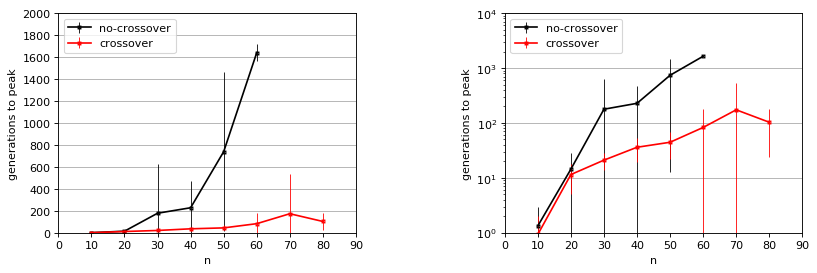

In [14]:
cross_mean = desc['crossover']['mean']
cross_std = desc['crossover']['std']
cross_bit = desc.index

mut_mean = desc['mutation']['mean']
mut_std = desc['mutation']['std']
mut_bit = desc.index

fig = plt.figure(figsize=(12, 8), dpi=80)
ax = fig.add_subplot(2,2, 1)
ax.errorbar(mut_bit, mut_mean, mut_std, marker='s', mfc='black',
         mec='black', ms=0.5, mew=3,elinewidth = 0.75, label = 'no-crossover', ecolor = "black", color = "black")

ax.errorbar(cross_bit, cross_mean, cross_std, marker='s', mfc='red',
         mec='red', ms=0.5, mew=3,elinewidth = 0.75, label = 'crossover', ecolor = "red", color = "red")

plt.gca().yaxis.grid(True)
plt.xlabel('n')

plt.gca().set_ylim([0,2000])
plt.ylabel('generations to peak')
plt.legend(loc = 'upper left')
plt.gca().set_xlim([0,90])
plt.xticks(np.arange(0, 100, 10))
plt.yticks(np.arange(0, 2200, 200))
ax2 = fig.add_subplot(2,2, 2)
ax2.errorbar(mut_bit, mut_mean, mut_std, marker='s', mfc='black',
         mec='black', ms=0.5, mew=3,elinewidth = 0.75, label = 'no-crossover', ecolor = "black", color = "black")

ax2.errorbar(cross_bit, cross_mean, cross_std, marker='s', mfc='red',
         mec='red', ms=0.5, mew=3,elinewidth = 0.75, label = 'crossover', ecolor = "red", color = "red")

plt.gca().yaxis.grid(True)
plt.xlabel('n')
plt.ylabel('generations to peak')
plt.legend(loc = 'upper left')
plt.yscale('log')
plt.gca().set_ylim([1,10000])
plt.gca().set_xlim([0,90])
plt.subplots_adjust(wspace = 0.5)
plt.xticks(np.arange(0, 100, 10))
plt.savefig('results_reimp.pdf')
